# Chapter5 - Practice

**sklearn.cross_validation** is to be deprecated so use **sklearn.model_selection**

In [41]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, RepeatedKFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-whitegrid')

/Users/Young/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
Auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()

In [4]:
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


# 5.1 Cross-Validation

## Figure 5.2

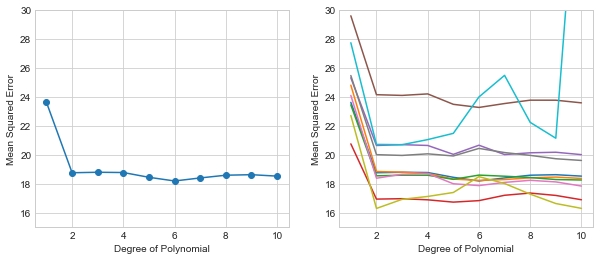

In [5]:
test_p = 0.5
# p_order will be used to generate 10 MSE based on polynormial order. 
p_order = np.arange(1,11)
# r_state will be used as (1) random seed for train_test_split and
# (2) will be used to calculate 10 validation method results.
r_state = np.arange(0,10)

xx,yy = np.meshgrid(p_order, r_state, indexing='xy')
Z = np.zeros((r_state.size,p_order.size))

# Z = [[MSE for p=1, MSE for p=2, ..., MSE for p=10], <- first try
#      [MSE for p=1, MSE for p=2, ..., MSE for p=10], <- second try
#       ...
#      [MSE for p=1, MSE for p=2, ..., MSE for p=10]] <- tenth try
#

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(xx[i,j])
    X_poly = poly.fit_transform(Auto['horsepower'].values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, Auto['mpg'].values,
                                                       test_size=test_p, random_state=yy[i,j])
    
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, axes = plt.subplots(1,2, figsize=(10,4))

# Left Plot
axes[0].plot(xx[0], Z[0], '-o')

# Right Plot
for i in range(10):
    axes[1].plot(xx[i],Z[i])
    
for ax in axes:
    ax.set_ylabel("Mean Squared Error")
    ax.set_ylim(15,30)
    ax.set_xlabel("Degree of Polynomial")

## Figure 5.4

In [6]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LOOCV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(Auto['horsepower'].values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, Auto['mpg'], cv=loo, 
                           scoring='neg_mean_squared_error').mean()
    scores.append(score)

In [7]:
# K-fold CV
folds = 10

xx, yy = np.meshgrid(p_order, r_state, indexing='xy')
Z = np.zeros((r_state.size, p_order.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(xx[i,j])
    X_poly = poly.fit_transform(Auto['horsepower'].values.reshape(-1,1))
    # Shuffle should be set to True
    # This will make different K-folds be selected based on row number i.
    kf_10 = KFold(n_splits=folds, shuffle=True,
                         random_state = yy[i,j])
    Z[i,j] = cross_val_score(regr, X_poly, Auto['mpg'], cv=kf_10,
                             scoring='neg_mean_squared_error').mean()


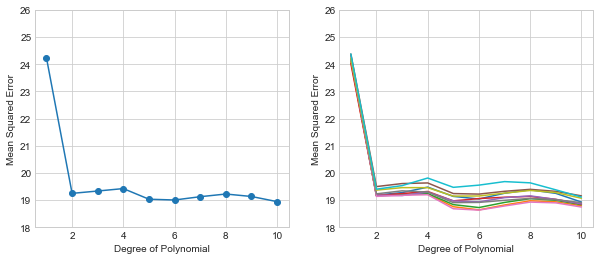

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

# cross_val_score() returns 'negative' mean squared error in order to
# follow the convention that higher return values are better than lower return values

# Left Plot
axes[0].plot(p_order, np.array(scores)*-1, '-o')

# Right Plot
for i in range(10):
    axes[1].plot(xx[i],Z[i]*-1)
    
for ax in axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(18, 26)
    ax.set_xlabel('Degree of Polynomial')

In page 183, the book stated that "Since the mean of many correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated, the test error estimate resulting from LOOCV tends to have higher variance than does the test error estimate resulting from k-fold CV.

I was curious why this statement holds and found the answer from [Stack Exchange](https://stats.stackexchange.com/questions/61783/variance-and-bias-in-cross-validation-why-does-leave-one-out-cv-have-higher-var) and [Wikipedia](https://en.wikipedia.org/wiki/Variance#Sum_of_correlated_variables). If you have a problem understanding this statement, hope these links help you.

# 5.2 The Bootstrap
## Figure 5.9

In [9]:
from scipy.stats import multivariate_normal
np.random.seed(1)
rv = multivariate_normal([0,0], [[1,0.5],[0.5,1.25]])

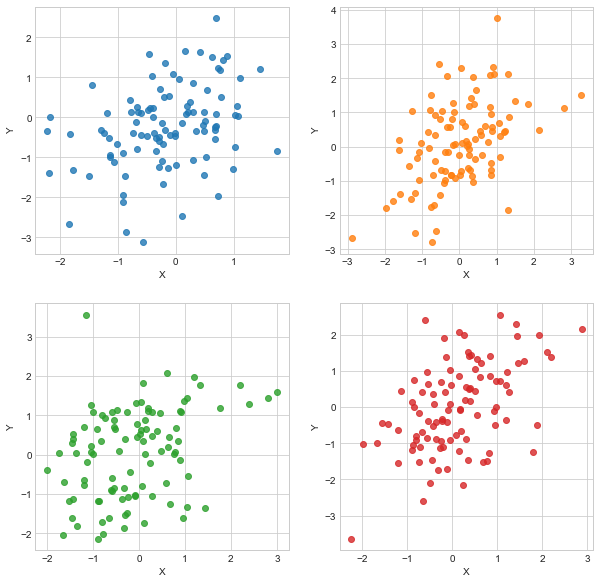

In [10]:
samples = [[0 for num in range(2)] for num in range(2)]

fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        samples[i][j] = rv.rvs(100)
        sns.regplot(samples[i][j][:,0], samples[i][j][:,1],
                   ax=ax, fit_reg=None)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

## Figure 5.10
Calculate $\bar{\alpha}$ with 1,000 simulated data sets from the true population

In [11]:
def calc_alpha(sample, index):
    cov = np.cov(sample[index], rowvar=False)
    alpha = (cov[1][1] - cov[1][0]) / (cov[0][0] + cov[1][1] - 2*cov[1][0])
    return alpha

In [12]:
# 1000 random samples from True distribution
np.random.seed(1)
samples = [rv.rvs(100) for num in range(1000)]

alpha_list_pop = []
for i in range(1000):
    alpha_list_pop.append(calc_alpha(samples[i],range(100)))

alpha_mean = sum(alpha_list_pop)/len(alpha_list_pop)
print('alpha_mean: {:.4f}'.format(alpha_mean))

alpha_mean: 0.6038


Calculate $\bar{\alpha}$ with 1,000 bootstrap samples from a single data set

In [13]:
# I used a sample from Lab 5.3.4
portfolio = pd.read_csv('Data/Portfolio.csv', usecols=(1,2))
data_set = portfolio.values

In [14]:
# repeat B times
np.random.seed(1)
B = 1000
alpha_list_boots = []

for i in range(B):
    # sample with replacement from sample size 100
    alpha_list_boots.append(calc_alpha(data_set, np.random.choice(100,100)))
    
alpha_mean_boots = sum(alpha_list_boots)/len(alpha_list_boots)
print('alpha_mean(bootstrap): {:.4f}'.format(alpha_mean_boots))

alpha_mean(bootstrap): 0.5785


In [15]:
df1 = DataFrame({'alpha':alpha_list_pop, 'Category':'True'})
df2 = DataFrame({'alpha':alpha_list_boots, 'Category':'Bootstrap'})
df = df1.append(df2)

(0.25, 0.95)

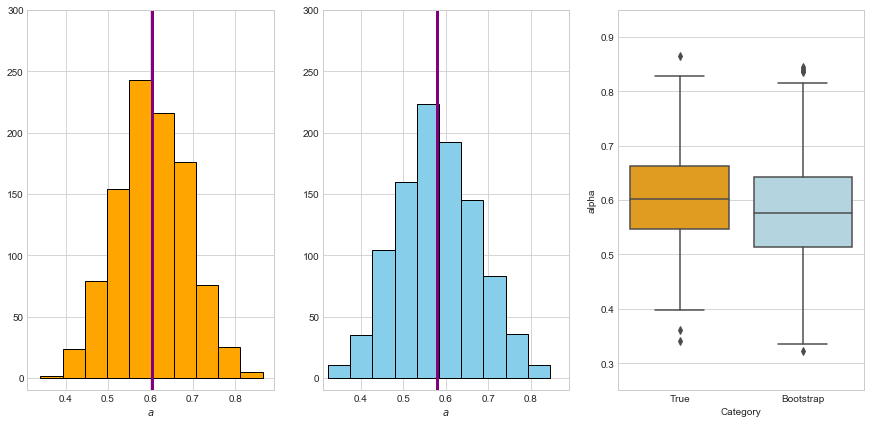

In [16]:
fig, axes = plt.subplots(1,3,figsize=(15,7))

# Left and Center Plot
sns.distplot(alpha_list_pop, kde=False, ax=axes[0], bins=10,
             hist_kws={"color":"orange","edgecolor":"k", "alpha":1})
sns.distplot(alpha_list_boots, kde=False, ax=axes[1], bins=10,
             hist_kws={"color":"skyblue","edgecolor":"k", "alpha":1})
axes[0].plot([alpha_mean]*2,[-10,300], color="purple", lw=3)
axes[1].plot([alpha_mean_boots]*2,[-10,300], color="purple", lw=3)

for i in range(2):
    axes[i].set_xlabel("$a$")
    axes[i].set_ylim([-10,300])
    axes[i].set_xlim([0.31,0.89])
    
# Right Plot
c_palette = {'Bootstrap':'lightblue', 'True':'orange'}
sns.boxplot('Category', 'alpha', data=df, orient='v', ax=axes[2], palette=c_palette)

axes[2].set_ylim([0.25, 0.95])

**Standard deviation of estimates for True and Bootstrap**

In [17]:
se_true = np.std(alpha_list_pop, ddof=1)
se_bootstrap = np.std(alpha_list_boots, ddof=1)

In [18]:
print(se_true)
print(se_bootstrap)

0.0830014346712
0.0929614170244


## Lab 5.3.4 Bootstrap
Estimating the Accuracy of a Linear Regression Model

In [57]:
# For bootstrap, make it a sequence of continuous integers.
# It is easier to use np.random.choice if we do that process.
Auto.index = list(range(392))

In [70]:
def boot_function(data):
    est = smf.ols('mpg ~ horsepower', data=Auto,
                 subset=np.random.choice(392,392)).fit()
    return est.params

$MPG = \beta_{0}+\beta_{1}\cdot Horsepower$

**Bootstrap**

In [73]:
# repeat B times
np.random.seed(1)

beta0_list = []
beta1_list = []
for i in range(B):
    est = smf.ols('mpg ~ horsepower', data=Auto,
                 subset=np.random.choice(392,392)).fit()
    beta0_list.append(est.params[0])
    beta1_list.append(est.params[1])

39.963384791778182

In [82]:
# Bootstrap Result
beta0_mean = np.mean(beta0_list)
beta1_mean = np.mean(beta1_list)
beta0_std = np.std(beta0_list)
beta1_std = np.std(beta1_list)
result = [[beta0_mean, beta0_std],[beta1_mean, beta1_std]]

result

[[39.963384791778182, 0.82526625288537681],
 [-0.15830569633840691, 0.007135734423653531]]

**Linear Regression**

In [84]:
est = smf.ols('mpg ~ horsepower', data=Auto).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 17 Jan 2018   Prob (F-statistic):           7.03e-81
Time:                        09:14:57   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$MPG = \beta_{0}+\beta_{1}\cdot Horsepower+\beta_{2}\cdot Horsepower^{2}$

**Bootstrap Result**

In [85]:
# repeat B times
np.random.seed(1)

beta0_list = []
beta1_list = []
beta2_list = []
for i in range(B):
    est = smf.ols('mpg ~ horsepower + np.power(horsepower,2)', data=Auto,
                 subset=np.random.choice(392,392)).fit()
    beta0_list.append(est.params[0])
    beta1_list.append(est.params[1])
    beta2_list.append(est.params[2])

In [86]:
# Bootstrap Result
beta0_mean = np.mean(beta0_list)
beta1_mean = np.mean(beta1_list)
beta2_mean = np.mean(beta2_list)
beta0_std = np.std(beta0_list)
beta1_std = np.std(beta1_list)
beta2_std = np.std(beta2_list)
result = [[beta0_mean, beta0_std],[beta1_mean, beta1_std],
          [beta2_mean, beta2_std]]

result

[[56.922106513538921, 2.102324921308],
 [-0.46690916730233084, 0.033502107369908482],
 [0.0012343786380714097, 0.00012109767372427118]]

**Linear Regression**

In [87]:
est = smf.ols('mpg ~ horsepower + np.power(horsepower,2)', data=Auto).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Wed, 17 Jan 2018   Prob (F-statistic):           5.40e-99
Time:                        09:24:37   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  56.9001      1.800     31.604      0.000      53.360      60.440
horsepower                 -0.4662      0.031    -14.978      0.000      -0.527      -0.405
np.power(horsepower, 2)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now you can see that the results from Bootstrap and Linear Regression are similar to each other since we considered non-linearity in the data.